In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dateutil.relativedelta import relativedelta
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


## Step 2: Load and Preprocess Data

In [26]:
df = pd.read_excel('CPI_monthly_2025_changes.xlsx', skiprows=11)
df = df.drop(columns=['Series ID'])

# Keep only monthly data
df = df[df['Period'].str.startswith('M')]

# Convert 'Year' & 'Period' into a proper Date format
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01')

# Keep only relevant columns
df = df[['Date', 'Value']]
df.columns = ['timestamp', 'CPI']

# Set date as index
df = df.set_index('timestamp')

# Outlier Treatment
q1 = np.percentile(df['CPI'], 25)
q3 = np.percentile(df['CPI'], 75)
boolean_condition = (df['CPI'] < q1 - (q3-q1)*1.3) | (df['CPI'] > q3 + (q3-q1)*1.3)
df.loc[boolean_condition, 'CPI'] = np.mean(df['CPI'])


## Step 3: Holt-Winters Experiment

In [27]:
train_size = int(0.9 * df.shape[0])
HW_train = df.iloc[:train_size]
HW_test = df.iloc[train_size:]


## Train and Forecast Holt-Winters Model

In [28]:
# Fit Holt-Winters model
hw_model = ExponentialSmoothing(HW_train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
hw_fit = hw_model.fit()

# Forecast
hw_forecast = hw_fit.forecast(steps=len(HW_test))


## Compute Performance Metrics

In [29]:
hw_rmse = np.sqrt(mean_squared_error(HW_test['CPI'], hw_forecast))
hw_mae = mean_absolute_error(HW_test['CPI'], hw_forecast)

print("Holt-Winters Performance:")
print(f"RMSE: {hw_rmse:.4f}")
print(f"MAE: {hw_mae:.4f}")


Holt-Winters Performance:
RMSE: 0.2868
MAE: 0.2130


## Plot Forecast vs Actual

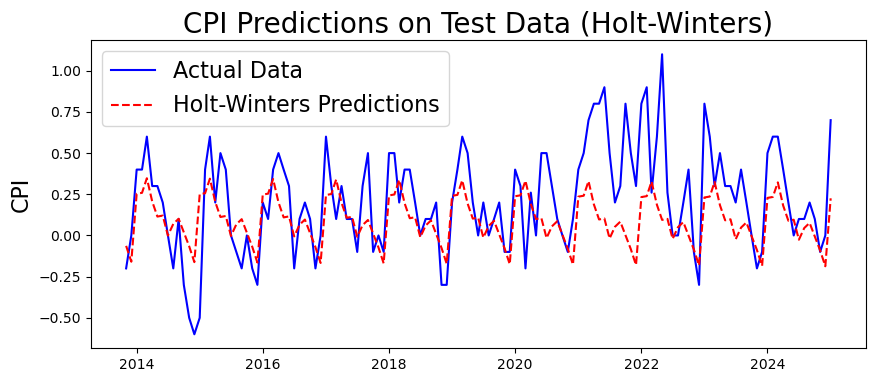

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(HW_test.index, HW_test['CPI'], label='Actual Data', color='blue')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Predictions', linestyle='--', color='red')
plt.legend(fontsize=16)
plt.title('CPI Predictions on Test Data (Holt-Winters)', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.show()




## Step 4: Holt-Winters Rolling Forecast

Rolling forecast for 2014-01-01 00:00:00: 0.27440473174752056
Rolling forecast for 2014-02-01 00:00:00: 0.3632930210243629
Rolling forecast for 2014-03-01 00:00:00: 0.22167038401474082
Rolling forecast for 2014-04-01 00:00:00: 0.12996395633043176
Rolling forecast for 2014-05-01 00:00:00: 0.1357915733884944
Rolling forecast for 2014-06-01 00:00:00: 0.014158671675816026
Rolling forecast for 2014-07-01 00:00:00: 0.08549816902600135
Rolling forecast for 2014-08-01 00:00:00: 0.1165067930056381
Rolling forecast for 2014-09-01 00:00:00: 0.01317237202038328
Rolling forecast for 2014-10-01 00:00:00: -0.058967554764747535
Rolling forecast for 2014-11-01 00:00:00: -0.1366822076533617
Rolling forecast for 2014-12-01 00:00:00: 0.27495556629778717
Rolling forecast for 2015-01-01 00:00:00: 0.27205292233762696
Rolling forecast for 2015-02-01 00:00:00: 0.3609404060567014
Rolling forecast for 2015-03-01 00:00:00: 0.21932406569266744
Rolling forecast for 2015-04-01 00:00:00: 0.12761962680140587
Rolling f

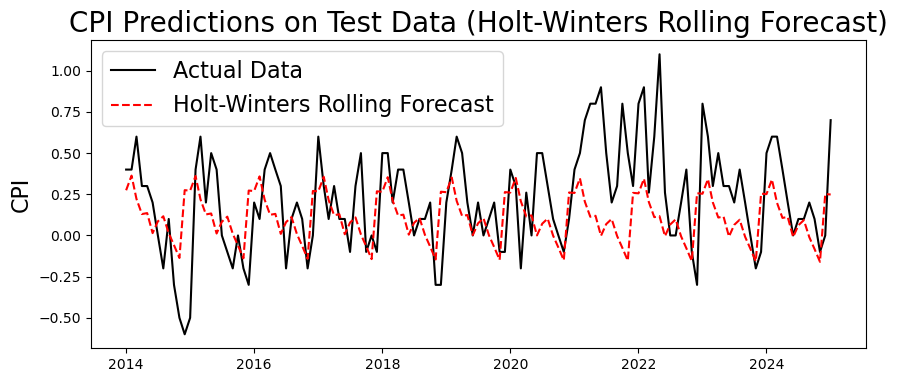

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Set rolling forecast start and end times
start_time = datetime(1913, 1, 1)
end_time = datetime(2014, 1, 1)

roll_end_time = end_time
HW_roll_train = df.loc[:end_time].copy()  # Copy data until end_time

# List to store rolling predictions
rolling_forecast = []

# Rolling forecast loop
while roll_end_time in df.index:  # Ensure roll_end_time exists in dataset
    # Select current rolling test point
    HW_roll_test = df.loc[roll_end_time:roll_end_time]

    # Train Holt-Winters model on rolling training set
    HW_roll_model = ExponentialSmoothing(HW_roll_train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
    HW_roll_model_fit = HW_roll_model.fit()

    # Forecast next step
    HW_roll_predictions = HW_roll_model_fit.forecast(steps=1)

    # Store forecasted values
    rolling_forecast.append((roll_end_time, float(HW_roll_predictions)))

    # Print rolling forecast progress
    print(f"Rolling forecast for {roll_end_time}: {float(HW_roll_predictions)}")

    # Move to next month
    roll_end_time = roll_end_time + relativedelta(months=+1)

    # Append the prediction to the rolling training set
    new_entry = pd.DataFrame({'CPI': [float(HW_roll_predictions)]}, index=[roll_end_time])
    HW_roll_train = pd.concat([HW_roll_train, new_entry])

# Convert rolling forecast list to DataFrame
HW_rolling_results = pd.DataFrame(rolling_forecast, columns=['timestamp', 'CPI']).set_index('timestamp')

# Plot Rolling Forecast Results
plt.figure(figsize=(10, 4))
plt.plot(df.loc[end_time:], label="Actual Data", color="black")
plt.plot(HW_rolling_results.index, HW_rolling_results['CPI'], label="Holt-Winters Rolling Forecast", linestyle="--", color="red")
plt.legend(fontsize=16)
plt.title("CPI Predictions on Test Data (Holt-Winters Rolling Forecast)", fontsize=20)
plt.ylabel("CPI", fontsize=16)
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure rolling test data is correctly indexed
HW_test_rolling = df.loc[end_time:].copy()

# Find common dates
common_dates = HW_rolling_results.index.intersection(HW_test_rolling.index)

# Extract matching values
rolling_actuals = HW_test_rolling.loc[common_dates, 'CPI']
rolling_predictions = HW_rolling_results.loc[common_dates, 'CPI']

# Compute RMSE and MAE
hw_rolling_rmse = np.sqrt(mean_squared_error(rolling_actuals, rolling_predictions))
hw_rolling_mae = mean_absolute_error(rolling_actuals, rolling_predictions)

print("📊 Holt-Winters Rolling Forecast Performance:")
print(f"✅ RMSE: {hw_rolling_rmse:.4f}")
print(f"✅ MAE: {hw_rolling_mae:.4f}")


📊 Holt-Winters Rolling Forecast Performance:
✅ RMSE: 0.3211
✅ MAE: 0.2464


In [ ]:
# Convert rolling forecast list to DataFrame
if len(rolling_forecast) == 0:
    raise ValueError("Rolling forecast list is empty. Ensure predictions were generated correctly.")

prophet_rolling_results = pd.DataFrame(rolling_forecast)

# Ensure 'ds' exists before converting
if 'ds' not in prophet_rolling_results.columns:
    raise KeyError("Column 'ds' not found in rolling forecast results. Check data structure.")

# Convert 'ds' to datetime
prophet_rolling_results['ds'] = pd.to_datetime(prophet_rolling_results['ds'])
prophet_rolling_results = prophet_rolling_results.set_index('ds')

# Print to confirm results
print("Fixed Prophet Rolling Forecast Sample:")
print(prophet_rolling_results.head())


ValueError: Rolling forecast list is empty. Ensure predictions were generated correctly.

In [ ]:
# Convert rolling forecast list to DataFrame
if len(rolling_forecast) == 0:
    raise ValueError("Rolling forecast list is empty. Ensure predictions were generated correctly.")

prophet_rolling_results = pd.DataFrame(rolling_forecast)

# Ensure 'ds' exists before converting
if 'ds' not in prophet_rolling_results.columns:
    raise KeyError("Column 'ds' not found in rolling forecast results. Check data structure.")

# Convert 'ds' to datetime
prophet_rolling_results['ds'] = pd.to_datetime(prophet_rolling_results['ds'])
prophet_rolling_results = prophet_rolling_results.set_index('ds')

# Print to confirm results
print("Fixed Prophet Rolling Forecast Sample:")
print(prophet_rolling_results.head())


ValueError: Rolling forecast list is empty. Ensure predictions were generated correctly.